In [1]:
%%capture
!pip install transformers
!pip install sentencepiece

In [34]:
import os
from IPython.display import Audio, clear_output

import tensorflow as tf
import tensorflow.keras as ks
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

import sentencepiece
from transformers import AlbertTokenizer, TFAlbertModel

seed = 42

In [3]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = TFAlbertModel.from_pretrained("albert-base-v2")

In [7]:
EMO = ['Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other']
VAD = ['valence', 'activation', 'dominance']

## Preprocessing

### Dataset download

In [8]:
from google.colab import files

def download_dataset_from_kaggle_to_colab():
    files.upload()
    !ls -lha kaggle.json
    !pip install -q kaggle # Install kaggle API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d riccardopaolini/nlp-project-work
    !unzip nlp-project-work.zip
    clear_output()

download_dataset_from_kaggle_to_colab()

In [9]:
def build_IEMOCAP_dataframe():
    folder = os.path.join(os.getcwd(), 'IEMOCAP')

    conv_id = 0

    df = []
    for session in ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']:
        session_path = os.path.join(folder, session)
        # 'dialogue' folder contains Emotions and Transcripts
        # 'sentences' folder contains Audios

        trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

        for trans_name in os.listdir(trans_folder):
            if trans_name[:2] != '._':
                emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
                with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                    conv_id += 1
                    turn_id = 1
                    for line in trans_file:
                        #print(line.split('_'))
                        audio_name, text = line.split(':')
                        if trans_name.split('.')[0] in audio_name:

                            wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')
                            if not os.path.exists(wav_path):
                                continue

                            reached = False
                            count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                            for emo_line in emo_file:
                                if audio_name.split(' ')[0] in emo_line:
                                    emotion, vad = emo_line.split('\t')[-2:]
                                    vad = vad[1:-2].split(',')
                                    reached = True
                                elif emo_line[0] == 'C' and reached:
                                    evaluator = emo_line.split(':')[0]
                                    emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                    emotions = [em.strip() for em in emotions]
                                    for em in emotions:
                                        if em != '':
                                            count_em[em] += 1
                                elif reached:
                                    emo_file.seek(0)
                                    break
                                        
                            if 0 <= float(vad[0]) <= 5 and 0 <= float(vad[1]) <= 5 and 0 <= float(vad[2]) <= 5:
                                row = {'conv_id': conv_id, 
                                        'turn_id': turn_id, 
                                        'sentence': text.strip(),
                                        'path': wav_path,
                                        'emotion': emotion,
                                        'valence': float(vad[0]),
                                        'activation': float(vad[1]),
                                        'dominance': float(vad[2])
                                        }
                                
                                df.append(dict(**row, **count_em))
                                turn_id += 1

    return pd.DataFrame(df)

df = build_IEMOCAP_dataframe()
df.head(2)

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,What's he going to say?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.0,2.3333,2.3333,0,0,0,0,2,0,1,0,0,0
1,1,2,Maybe we should tell him before he sees it.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,xxx,2.0,2.3333,1.6667,0,0,0,1,0,0,1,0,0,1


In [10]:
def preprocess(df, tokenizer, hist_length=3):

    # Store conversation HISTORY
    history = []
    for idx, row in df.iterrows():
        h = ''.join([df.loc[idx-t, 'sentence'] + ' ' for t in reversed(range(1, hist_length)) if idx-t >= 0 and df.loc[idx-t, 'conv_id'] == df.loc[idx, 'conv_id']])
        history.append(h)
    df['history'] = history

    # Prepend HISTORY to SENTENCE
    df['conv'] = df['history'] + f' {tokenizer.sep_token} ' + df['sentence'] 

    # Create EMOTION distribution labels
    df['distr'] = list(np.stack([df[col].to_numpy() for col in EMO], axis=-1) / np.expand_dims(np.sum(df.loc[:, EMO], axis=1), axis=-1))

    # Create VAD labels
    df['vad'] = list(np.stack([df[col].to_numpy() / 5 for col in VAD], axis=-1))

    return df

df = preprocess(df, tokenizer)
df.head(2)

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,...,Frustration,Excited,Fear,Surprise,Disgust,Other,history,conv,distr,vad
0,1,1,What's he going to say?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.0,2.3333,2.3333,0,0,...,2,0,1,0,0,0,,[SEP] What's he going to say?,"[0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, ...","[0.4, 0.46665999999999996, 0.46665999999999996]"
1,1,2,Maybe we should tell him before he sees it.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,xxx,2.0,2.3333,1.6667,0,0,...,0,0,1,0,0,1,What's he going to say?,What's he going to say? [SEP] Maybe we should...,"[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, ...","[0.4, 0.46665999999999996, 0.33334]"


In [11]:
x = df['conv']
y = df.loc[:, ['emotion', 'distr', 'vad']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000, random_state=seed)

print(f"Number of train samples: {x_train.shape[0]}")
print(f"Number of valid samples: {x_val.shape[0]}")
print(f"Number of test  samples: {x_test.shape[0]}")

Number of train samples: 8035
Number of valid samples: 1000
Number of test  samples: 1000


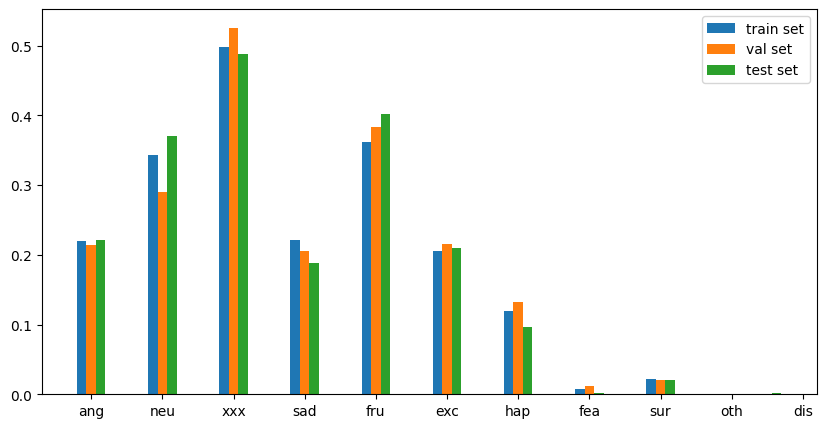

In [12]:
plt.figure(figsize=(10, 5))
plt.hist([y_train['emotion'], y_val['emotion'], y_test['emotion']], label=["train set", "val set", "test set"], bins=20, density=True, align='left')
plt.legend()
plt.show()

In [14]:
# Tokenize text
x_tokens = tokenizer(
    text = x_train.tolist(),
    add_special_tokens=True,
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

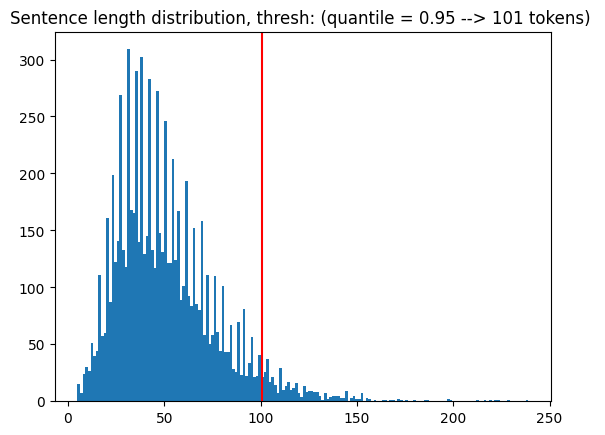

In [15]:
quantile = 0.95

# The length of the input must be evaluated in #tokens not in #words -> I have tokenized in the cell above
lengths = [len(x) for x in x_tokens['input_ids']] # Number of tokens
thresh = int(np.quantile(lengths, quantile))

plt.hist(lengths, bins = len(set(lengths)))
plt.title(f"Sentence length distribution, thresh: (quantile = {quantile} --> {thresh} tokens) ")
plt.axvline(x = thresh, color = 'r', label = 'axvline - full height')
plt.show()

## ALBERT

### Tokenization

In [16]:
# setting length cut-limit for the sentences
maxlen = thresh

x_train_albert = tokenizer(
    text = x_train.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_albert = tokenizer(
    text = x_val.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test_albert = tokenizer(
    text = x_test.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = "max_length",
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

### Prepare labels

In [37]:
encoded_dict= {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

em_train = y_train['emotion'].map(encoded_dict)
em_train = ks.utils.to_categorical(em_train)

em_val = y_val['emotion'].map(encoded_dict)
em_val = ks.utils.to_categorical(em_val)

em_test = y_test['emotion'].map(encoded_dict)
em_test = em_test


distr_train = np.array(list(y_train['distr']))
distr_val = np.array(list(y_val['distr']))
distr_test = np.array(list(y_test['distr']))

vad_train = np.array(list(y_train['vad']))
vad_val = np.array(list(y_val['vad']))
vad_test = np.array(list(y_test['vad']))

### Model definition

In [28]:
def get_model(input_length):
    # input
    input_ids = ks.layers.Input(shape=(input_length,), dtype=tf.int32, name="input_ids")
    input_mask = ks.layers.Input(shape=(input_length,), dtype=tf.int32, name="attention_mask")

    # pretrained 
    embeddings = albert([input_ids, input_mask])[0] #(0 is the last hidden layer, 1 means pooler output)

    # last layers and output
    out = ks.layers.GlobalMaxPool1D()(embeddings)
    out = ks.layers.Dense(64, activation='relu', activity_regularizer=ks.regularizers.L2())(out)
    out = ks.layers.Dropout(0.2)(out)
    out = ks.layers.Dense(32, activation = 'relu', activity_regularizer=ks.regularizers.L2())(out)
    out = ks.layers.Dropout(0.2)(out)

    y_dist = ks.layers.Dense(10, activation = 'softmax', name='dist_output')(out)

    y_em = ks.layers.Dense(11, activation = 'softmax', name='em_output')(tf.concat([out, y_dist], -1))

    y_vad = ks.layers.Dense(3, activation = 'linear', name='vad_output')(out)

    model = ks.Model(inputs=[input_ids, input_mask], outputs = [y_em, y_vad, y_dist])
    model.layers[2].trainable = True
    return model

model = get_model(maxlen)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 101)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 101)]        0           []                               
                                                                                                  
 tf_albert_model_2 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_ids[0][0]',              
 el)                            thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 101                                               
                                , 768),                                                     

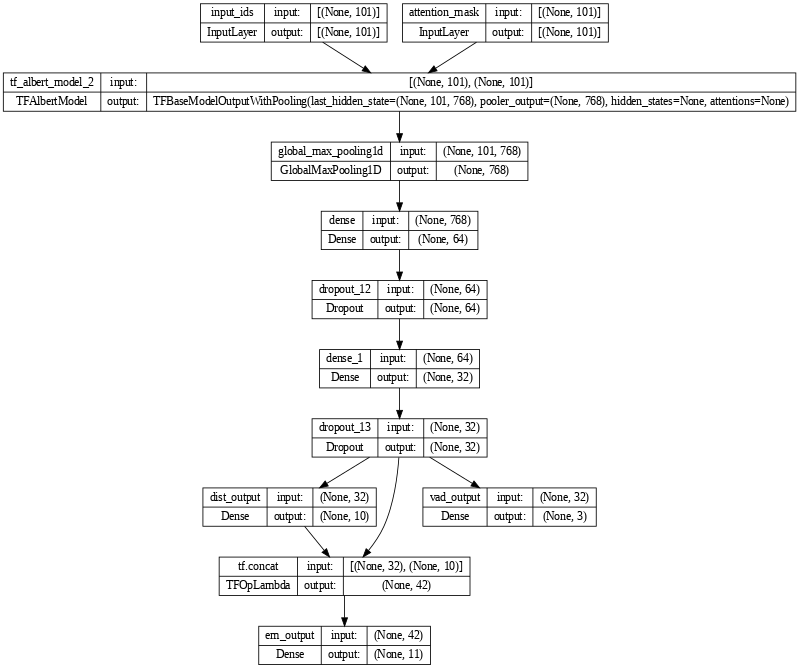

In [19]:
ks.utils.plot_model(model, show_shapes=True, dpi=60)

In [29]:
optimizer = ks.optimizers.Adam(learning_rate = 1e-05)

# Losses
losses = {
    "em_output": ks.losses.CategoricalCrossentropy(),
    "vad_output": ks.losses.MeanSquaredError(),
    "dist_output": ks.losses.KLDivergence()
}

lossWeights = {"em_output": 20.0, "vad_output": 1.0, "dist_output": 10.0}

# Metrics
metric = {
    "em_output": ks.metrics.CategoricalAccuracy(name='balanced_accuracy', dtype='float32'),
    "vad_output": ks.metrics.MeanSquaredError(),
    "dist_output": ks.metrics.KLDivergence()}

# compile the model
model.compile(
    optimizer = optimizer,
    loss = losses,
    metrics = metric,
    loss_weights = lossWeights,
)

In [30]:
albert_history = model.fit(
    x = {
            'input_ids'     : x_train_albert['input_ids'], 
            'attention_mask': x_train_albert['attention_mask']
         },   
    y = {
            'em_output'     : em_train,
            'dist_output'   : distr_train,
            'vad_output'    : vad_train
         },

    validation_data = (
        {
            'input_ids'     : x_val_albert['input_ids'], 
            'attention_mask': x_val_albert['attention_mask']
        }, 
        {
            'em_output'     : em_val,
            'dist_output'   : distr_val,
            'vad_output'    : vad_val,
        }),

    epochs=20, 
    batch_size=16,
    callbacks = [ks.callbacks.EarlyStopping(monitor='val_em_output_balanced_accuracy', patience=4, verbose=1, mode='max', restore_best_weights=True),
                 ks.callbacks.ReduceLROnPlateau(monitor="val_em_output_balanced_accuracy", factor=0.1, patience=2)]
)

Epoch 1/2


503/503 [==============================] - 219s 385ms/step - loss: 61.8658 - em_output_loss: 2.2950 - vad_output_loss: 0.3463 - dist_output_loss: 1.5373 - em_output_balanced_accuracy: 0.2154 - vad_output_mean_squared_error: 0.3463 - dist_output_kullback_leibler_divergence: 1.5373 - val_loss: 57.9872 - val_em_output_loss: 2.1695 - val_vad_output_loss: 0.3210 - val_dist_output_loss: 1.3997 - val_em_output_balanced_accuracy: 0.3000 - val_vad_output_mean_squared_error: 0.3210 - val_dist_output_kullback_leibler_divergence: 1.3997 - lr: 1.0000e-05
Epoch 2/2
503/503 [==============================] - 178s 353ms/step - loss: 56.3215 - em_output_loss: 2.0615 - vad_output_loss: 0.6794 - dist_output_loss: 1.3913 - em_output_balanced_accuracy: 0.2994 - vad_output_mean_squared_error: 0.6794 - dist_output_kullback_leibler_divergence: 1.3913 - val_loss: 51.4238 - val_em_output_loss: 1.8911 - val_vad_output_loss: 0.5448 - val_dist_output_loss: 1.2472 - val_em_output_balanced_accuracy: 0.3360 - val_vad

## Training results

In [31]:
# utility to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

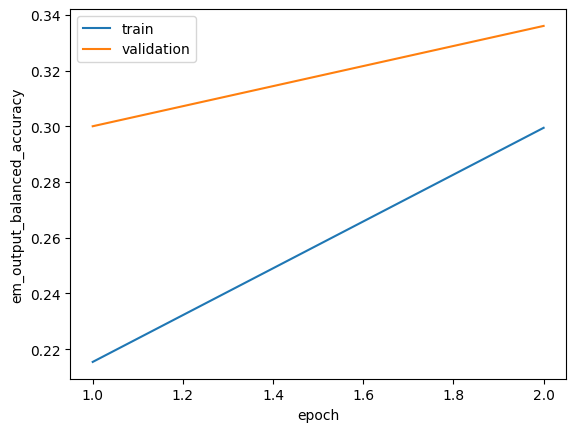

In [32]:
plot_history(albert_history, ['em_output_balanced_accuracy','val_em_output_balanced_accuracy'])

In [39]:
y_pred_albert = model.predict({'input_ids': x_test_albert['input_ids'],'attention_mask': x_test_albert['attention_mask']})

# convertion of the guessed label in integer labels
y_pred_albert = np.argmax(y_pred_albert[0], axis = 1)

f1_macro = f1_score(em_test, y_pred_albert, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

32/32 [==============================] - 8s 239ms/step
The final F1-score macro avg obtained on the test set is F1 = 0.1576957319271247


In [40]:
print(classification_report(em_test, y_pred_albert))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00         1
           2       0.38      0.05      0.08       105
           3       0.00      0.00      0.00         1
           4       0.54      0.32      0.40       201
           5       0.15      0.12      0.14        48
           6       0.00      0.00      0.00       185
           8       0.42      0.77      0.55        94
           9       0.00      0.00      0.00        10
          10       0.28      0.75      0.41       244

    accuracy                           0.33      1000
   macro avg       0.18      0.20      0.16      1000
weighted avg       0.26      0.33      0.25      1000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
